# Michibiki Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from spacepy import pycdf
from scipy.ndimage import uniform_filter1d

c:\Users\alexp\anaconda3\lib\site-packages\spacepy\time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


Functions to load noise

In [3]:
import utility
B = utility.load_michibiki_data() # shape = (n_sensor, n_axis, n_samples)
#B = B[:,:,::10]
noise = B[0] - B[1]

c:\Users\alexp\anaconda3\lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


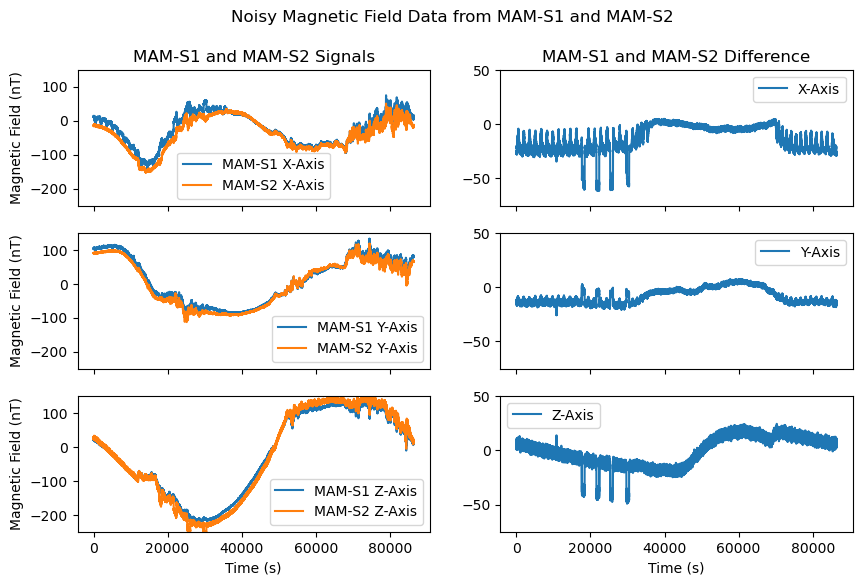

In [4]:
"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0,0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0,0].plot(B[0,0], label="MAM-S1 X-Axis")
axs[0,0].plot(B[1,0], label="MAM-S2 X-Axis")
axs[0,0].set_ylabel("Magnetic Field (nT)")
axs[0,0].set_ylim(-250, 150)
axs[0,0].legend()

axs[1,0].plot(B[0,1], label="MAM-S1 Y-Axis")
axs[1,0].plot(B[1,1], label="MAM-S2 Y-Axis")
axs[1,0].set_ylabel("Magnetic Field (nT)")
axs[1,0].set_ylim(-250, 150)
axs[1,0].legend()

axs[2,0].plot(B[0,2], label="MAM-S1 Z-Axis")
axs[2,0].plot(B[1,2], label="MAM-S2 Z-Axis")
axs[2,0].set_xlabel("Time (s)")
axs[2,0].set_ylabel("Magnetic Field (nT)")
axs[2,0].set_ylim(-250, 150)
axs[2,0].legend()

axs[0,1].set_title("MAM-S1 and MAM-S2 Difference")
axs[0,1].plot(B[1,0]-B[0,0], label="X-Axis")
axs[0,1].legend()
axs[0,1].set_ylim(-75, 50)

axs[1,1].plot(B[1,1]-B[0,1], label="Y-Axis")
axs[1,1].legend()
axs[1,1].set_ylim(-75, 50)

axs[2,1].plot(B[1,2]-B[0,2], label="Z-Axis")
axs[2,1].set_ylim(-75, 50)
axs[2,1].set_xlabel("Time (s)")
axs[2,1].legend()

plt.show()



Find Coupling Coefficients

In [34]:
from algorithms import RAMEN
from scipy.stats import pearsonr
import importlib
importlib.reload(RAMEN)

axis = 1
RAMEN.fs = 1
RAMEN.weights = np.geomspace(1,.1,B.shape[0])
RAMEN.sspTol = 5
RAMEN.flip = False

result_ramen = RAMEN.clean(np.copy(B[:,axis]), triaxial=False)

print(pearsonr(result_ramen, noise[axis])[0])
print(pearsonr(B[-1,axis], noise[axis])[0])
print(RAMEN.aii)

0.05983364642467797
0.08329265168860411
[[1.         1.        ]
 [1.         5.38511696]]


In [18]:
from algorithms import WAICUPV2
importlib.reload(WAICUPV2)
WAICUPV2.fs = 1
WAICUPV2.uf=10000
WAICUPV2.detrend = False
WAICUPV2.weights = np.geomspace(1,.1,B.shape[0])
WAICUPV2.gain_method = 'sheinker'
WAICUPV2.sspTol = 1
WAICUPV2.flip = False
result_waicup = WAICUPV2.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_waicup, noise[axis])[0])
print(pearsonr(B[-1,axis], noise[axis])[0])

c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\WAICUPV2.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  w_clean[s] = HOG(wn[:,s,:])


0.07291851314841508
0.08329265168860411


In [19]:
from algorithms import HOG
importlib.reload(HOG)

HOG.fs = .1
HOG.weights = np.geomspace(10,.1,B.shape[0])
HOG.sspTol = 14
HOG.gain_method = 'sheinker'
HOG.flip = True
result_hog= HOG.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_hog, noise[axis])[0])
print(pearsonr(B[-1,axis], noise[axis])[0])
#print(HOG.aii)

0.07078509423688155
0.08329265168860411


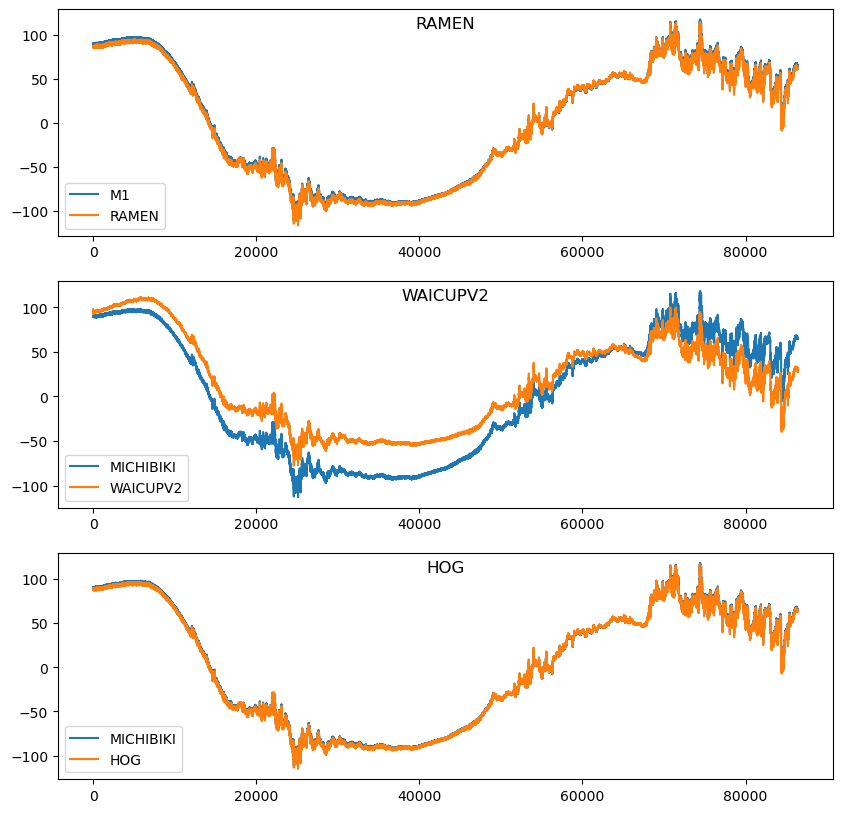

In [35]:
# Make 3,1 subplot and overlay swarm on each result. Set location of each title to within the plot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
#axs[0].plot(B[0,axis], label = 'M0')
axs[0].plot(B[-1,axis], label = 'M1')
axs[0].plot(result_ramen, label = 'RAMEN')
axs[0].set_title("RAMEN", y=1.0, pad=-14)
axs[0].legend()
axs[1].plot(B[-1,axis], label = 'MICHIBIKI')
axs[1].plot(result_waicup, label = 'WAICUPV2')

axs[1].set_title('WAICUPV2', y=1.0, pad=-14)
axs[1].legend()
axs[2].plot(B[-1,axis], label = 'MICHIBIKI')
axs[2].plot(result_hog, label = 'HOG')

axs[2].set_title('HOG', y=1.0, pad=-14)
axs[2].legend()


In [36]:
"Take Continuous Wavelet Transform"
import fcwt
fs= 1  # Hz
f0 = 0.0001  # Hz
f1 = 1 / 2  # Hz

# take transform of B_kplo Z-axis
freqs_michibiki, out_michibiki= fcwt.cwt(B[1,axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)
freqs_michibiki = np.flip(freqs_michibiki)

# take transform of WAICUP Z-axis
_, out_ramen = fcwt.cwt(result_ramen, fs, f0, f1, fn=300, scaling='linear', nthreads=12)

# take transform of B_kplo Z-axis
_, out_noise = fcwt.cwt(noise[axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)

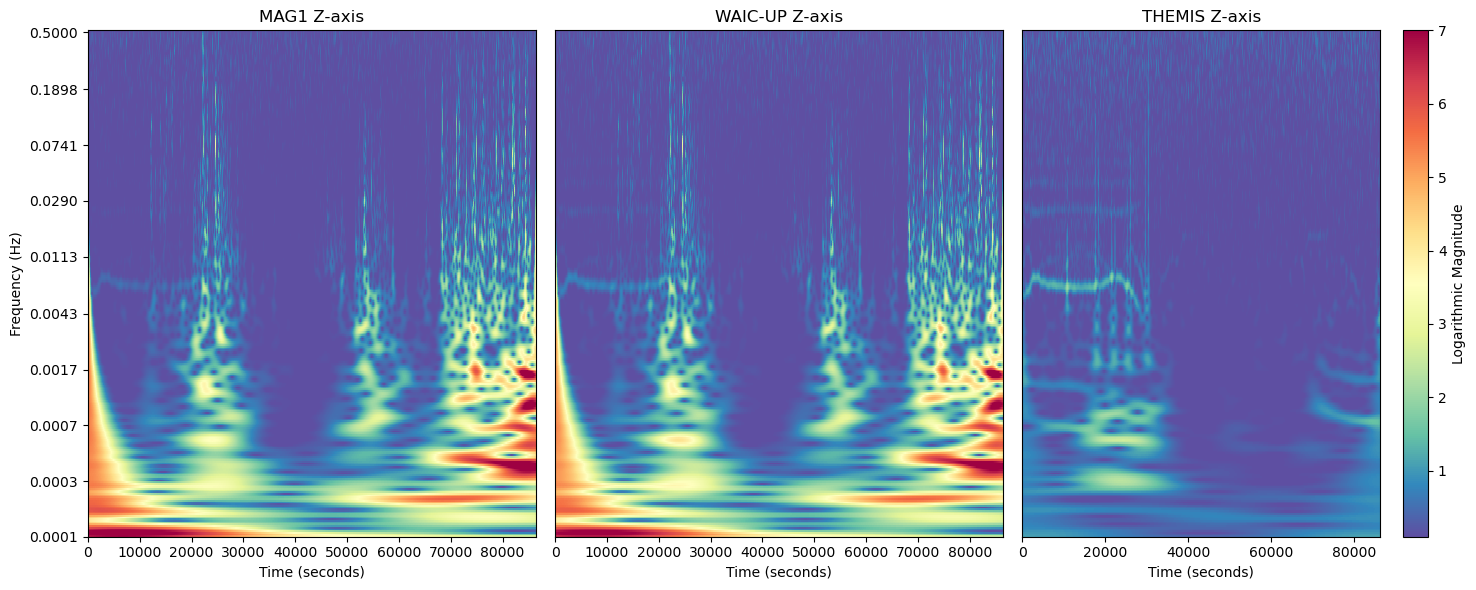

In [37]:

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
extent = [0, out_michibiki.shape[1] / fs, 0, out_michibiki.shape[0]]
cax1 = axs[0].imshow(np.abs(out_michibiki), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=7)
cax2 = axs[1].imshow(np.abs(out_ramen), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=7)
cax3 = axs[2].imshow(np.abs(out_noise), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=7)

#fig.colorbar(cax1, ax=axs[0], label='Logarithmic Magnitude')
#fig.colorbar(cax2, ax=axs[1], label='Logarithmic Magnitude')
fig.colorbar(cax3, ax=axs[2], label='Logarithmic Magnitude')

yticks_kplo = np.linspace(0, len(freqs_michibiki) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs_michibiki[i]:.4f}" for i in yticks_kplo]

axs[0].set_yticks(yticks_kplo)
axs[0].set_yticklabels(yticklabels_kplo)
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title("MAG1 Z-axis")

# TURN OFF YTICKS FOR AXS[1] AND AXS[2]
axs[1].set_yticks([])
axs[1].set_xlabel('Time (seconds)')
axs[1].set_title("WAIC-UP Z-axis")
axs[2].set_yticks([])
axs[2].set_xlabel('Time (seconds)')
axs[2].set_title("THEMIS Z-axis")


plt.tight_layout()
plt.show()


C:\Users\alexp\AppData\Local\Temp\ipykernel_5448\3692697717.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(yticklabels_kplo)


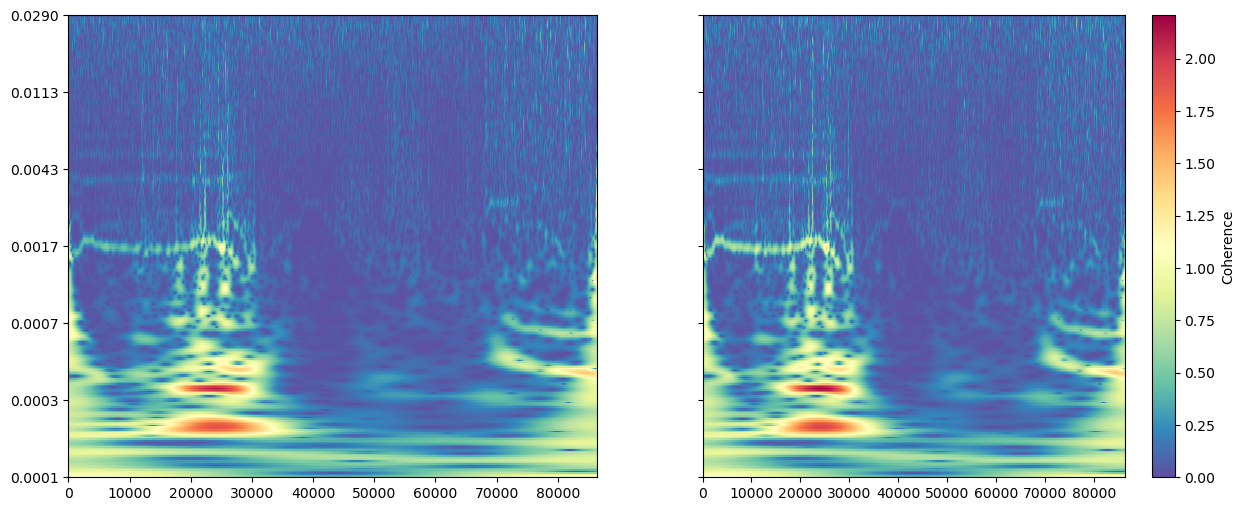

In [38]:
b_coherence = np.abs(out_michibiki*np.conj(out_noise)) / (np.abs(out_michibiki)**2+ np.abs(out_noise)**2)**.5
r_coherence = np.abs(out_ramen*np.conj(out_noise)) / (np.abs(out_ramen)**2 + np.abs(out_noise)**2)**.5
vmax =  np.max([np.abs(b_coherence), np.abs(r_coherence)])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
extent = [0, b_coherence.shape[1] / fs, 0, b_coherence.shape[0]]
cax1 = axs[0].imshow(b_coherence, aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=vmax)
cax2 = axs[1].imshow(r_coherence, aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=vmax)
axs[0].set_yticklabels(yticklabels_kplo)
axs[1].set_yticklabels([])
yticks_kplo = np.linspace(0, len(freqs_michibiki) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs_michibiki[i]:.3f}" for i in yticks_kplo]
fig.colorbar(cax2, ax=axs[1], label='Coherence')
